In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
df  = pd.read_excel("dataset.xlsx")

# EDA

## Analysis of the shape of the data

**Identification of the target data** 

In [4]:
df.columns

Index(['Unnamed: 0', 'itching', ' skin_rash', ' nodal_skin_eruptions',
       ' dischromic _patches', ' continuous_sneezing', ' shivering', ' chills',
       ' watering_from_eyes', ' stomach_pain',
       ...
       ' foul_smell_of urine', ' continuous_feel_of_urine', ' skin_peeling',
       ' silver_like_dusting', ' small_dents_in_nails', ' inflammatory_nails',
       ' blister', ' red_sore_around_nose', ' yellow_crust_ooze', 'Disease'],
      dtype='object', length=133)

Here our target data is the class `Disease`. We will train a model to predict this class.

We can also get rid of the `Unnamed: 0` class, which is just an index.

In [5]:
df = df.drop(['Unnamed: 0'], axis=1)

**Number of rows and columns**

In [6]:
df.columns.value_counts().sum()

132

In [7]:
df.count()[0]

4920

We have 132 columns and 4920 rows

**Types of variables**

In [8]:
df.dtypes.value_counts()

int64     131
object      1
dtype: int64

We have 131 variables of type `int64`, they correspond to the inputs of the model. We have 1 variable of type `object`, which corresponds to the target of the model.

**Missing values**

In [9]:
df.isna().sum().sum()

0

There are no missing values in the dataset.

## Deep data analysis

**Target visualization**

We can visualize the distribution of the different values in the `Disease` class with a pie chart

<AxesSubplot:ylabel='Disease'>

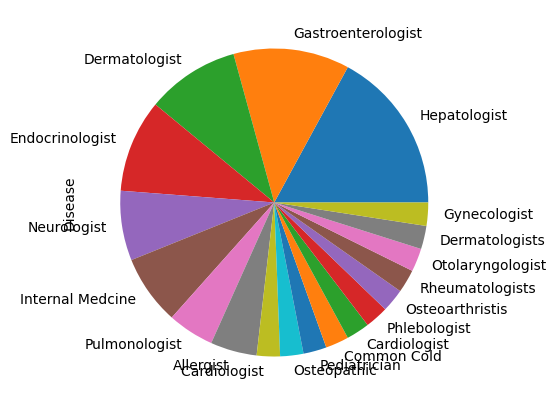

In [10]:
df['Disease'].value_counts().plot(kind='pie', figsize=(5, 5))

We can also count the number of unique values in this class

In [11]:
df['Disease'].nunique()

19

There are 19 unique values in the `Disease` class. And these values are quite balanced 

## Understanding the input data

As we saw earlier, our dataset contains 131 input variables. Every single one of these variables is a binary variable, meaning that it can only take the values 0 or 1.

These variables represent the presence or absence of different symptoms, diseases, or conditions.

For example, if the variable `stomach_pain` is equal to one, it means that the patient has stomach pain. If it is equal to zero, it means that the patient does not have stomach pain.

To understand the relation between the input variables and the target variable, we will plot the correlation matrix.

/tmp/ipykernel_1116/2207029119.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot:>

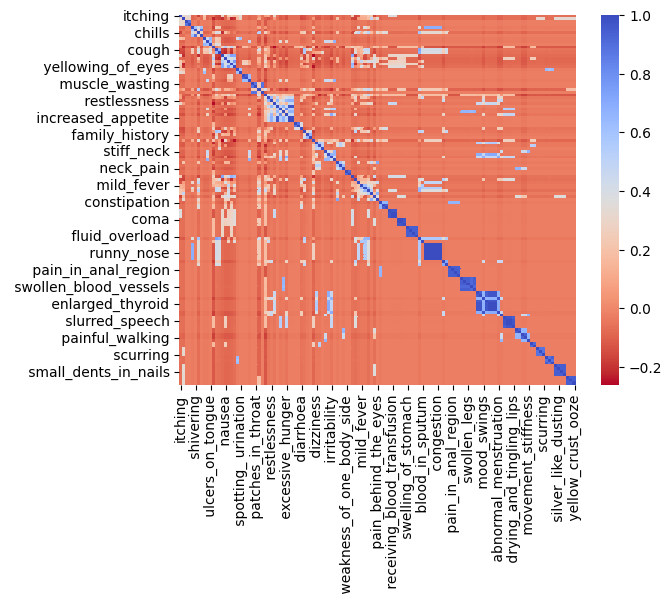

In [12]:
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})

To make it easier to read, we will plot the correlation matrix with a clustermap. This will group the variables with a high correlation together.

/home/sacha/.local/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


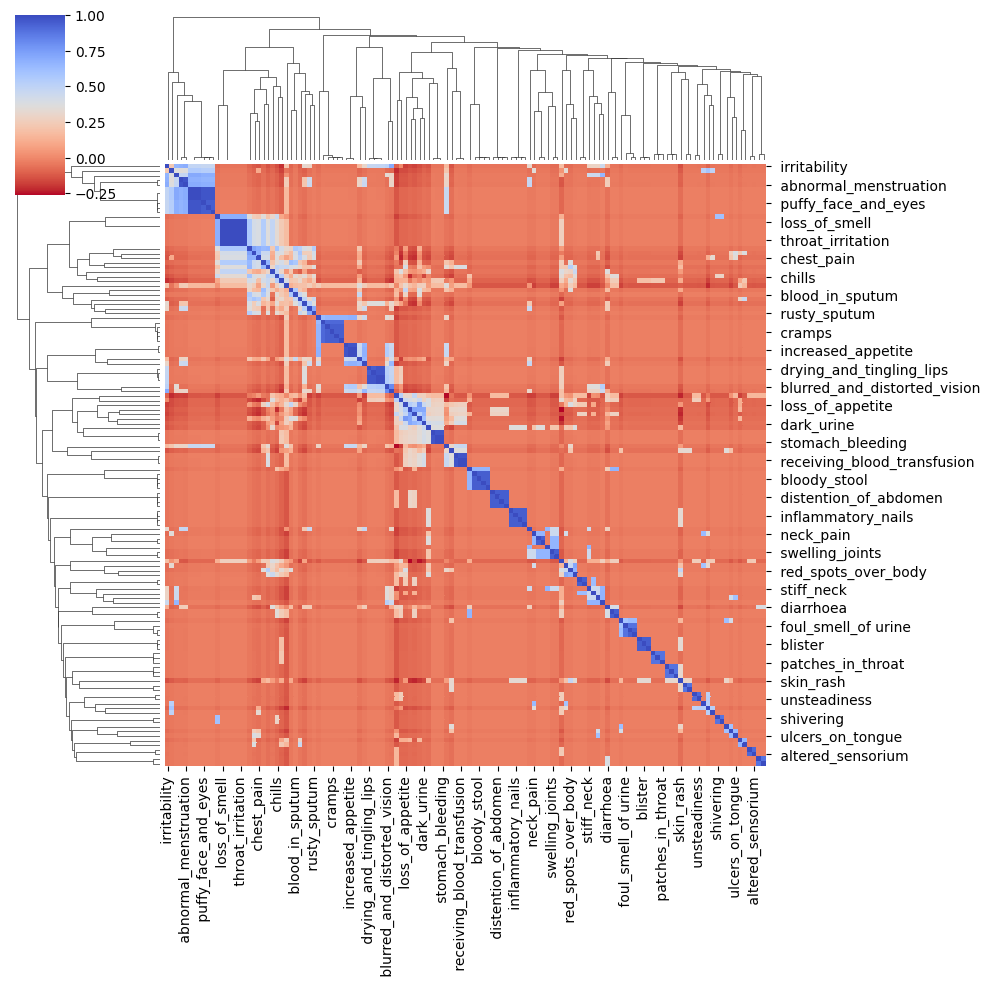

In [13]:
sns.clustermap(corr, cmap='coolwarm_r', annot_kws={'size':20})

## Conclusion of the EDA

We have a dataset with 131 input variables and 1 target variable. The input variables are binary, and they represent the presence or absence of different symptoms, diseases, or conditions.

# Model training

**Choosing the model**

We want to predict the class of the `Disease` variable. This is a classification problem.

Moreover, the input data is not a 1D or 2D signal. So we don't need to use a convolutional neural network.

We will use simple machine learning models such as:

* Logistic regression
* Random forest
* AdaBoost
* SVM

But first, we need to split our data into a training set and a test set.

In [15]:
X,Y = df.drop('Disease',axis=1),df['Disease']

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [16]:
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.values
Y_test = Y_test.values

In [17]:
classifiers = {
    "LogisticRegression": LogisticRegression(),
    "RandomForest": RandomForestClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Support Vector Classifier": SVC()
}

In [18]:
for classifier in classifiers:
    classifiers[classifier].fit(X_train,Y_train)
    training_score = cross_val_score(classifiers[classifier],X_train,Y_train,cv=5)
    print("Classifiers: ",classifier,"Has a training score of",round(training_score.mean(),2)*100,"% accuracy score")

Classifiers:  LogisticRegression Has a training score of 100.0 % accuracy score
Classifiers:  RandomForest Has a training score of 100.0 % accuracy score
Classifiers:  AdaBoost Has a training score of 32.0 % accuracy score
Classifiers:  Support Vector Classifier Has a training score of 100.0 % accuracy score


To understand the performance of our model, we will use the confusion matrix.

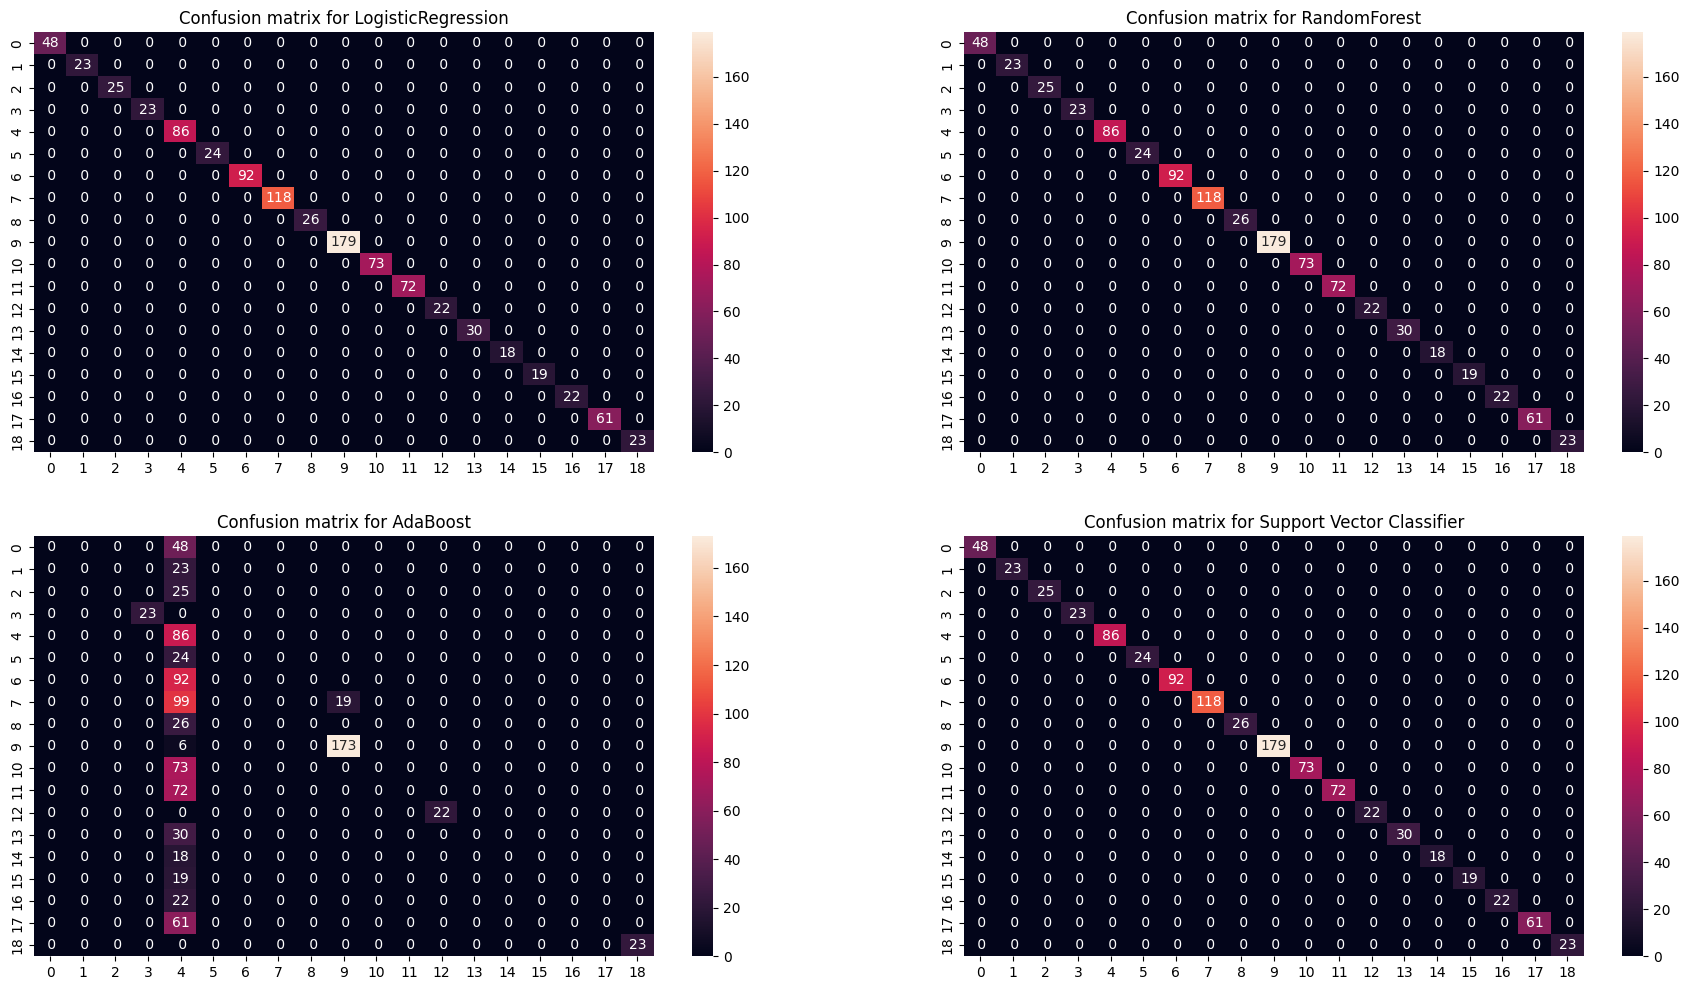

In [19]:
from sklearn.metrics import confusion_matrix

fig,ax = plt.subplots(2,2,figsize=(22,12))
n=0

for classifier in classifiers:
    Y_pred = classifiers[classifier].predict(X_test)
    i,j = divmod(n,2)
    sns.heatmap(confusion_matrix(Y_test,Y_pred),ax=ax[i][j],annot=True,fmt='2.0f')
    ax[i][j].set_title("Confusion matrix for {}".format(classifier))
    n+=1

All the models seem to have an excellent performance, except for the AdaBoost model.

**Hyperparameters optimization**

To find the best model, we will optimize the hyperparameters of each model.

We will use the GridSearchCV function to find the best hyperparameters for each model.

In [20]:
param_logistic = {
    'penalty':['l1','l2'],
    'C':np.logspace(0,4,10)
}

grid_logistic = sk.model_selection.GridSearchCV(LogisticRegression(),param_logistic,cv=5,verbose=True,n_jobs=-1)
print("Hyperparameter tuning for Logistic Regression")
grid_logistic.fit(X_train,Y_train)
log_reg = grid_logistic.best_estimator_

param_randomforest = {
    'n_estimators':[200,500],
    'max_features':['auto','log2'],
    'max_depth':[4,5,6,7,8,None],
    'criterion':['gini','entropy']
}

grid_randomforest = sk.model_selection.GridSearchCV(RandomForestClassifier(),param_randomforest,cv=5,verbose=True,n_jobs=-1)
print("Hyperparameter tuning for Random Forest")
grid_randomforest.fit(X_train,Y_train)
random_forest = grid_randomforest.best_estimator_

param_AdaBoost = {
    'n_estimators':[200,500],
    'learning_rate':[0.5,1.0]
}

grid_AdaBoost = sk.model_selection.GridSearchCV(AdaBoostClassifier(),param_AdaBoost,cv=5,verbose=True,n_jobs=-1)
print("Hyperparameter tuning for AdaBoost")
grid_AdaBoost.fit(X_train,Y_train)
AdaBoost = grid_AdaBoost.best_estimator_

param_SVM = {
    'C':[0.1,1,10,100],
    'gamma':[1,0.1,0.01,0.001],
    'kernel':['rbf','poly','sigmoid']
}

grid_SVM = sk.model_selection.GridSearchCV(SVC(),param_SVM,cv=5,verbose=True,n_jobs=-1)
print("Hyperparameter tuning for Support Vector Classifier")
grid_SVM.fit(X_train,Y_train)
SVM = grid_SVM.best_estimator_

Hyperparameter tuning for Logistic Regression
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/sacha/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/home/sacha/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/sacha/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/sacha/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise 

Hyperparameter tuning for Random Forest
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/home/sacha/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/sacha/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/sacha/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

Hyperparameter tuning for AdaBoost
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Hyperparameter tuning for Support Vector Classifier
Fitting 5 folds for each of 48 candidates, totalling 240 fits


Now that we have the best hyperparameters for each model, we can train our models.

We also want to plot the learning curve for each model.

The learning curve is crucial to select the best model, because it shows us if our model is overfitting or underfitting.

The lower the gap between the training score and the cross-validation score, the better our model is.

In [22]:
best_models = {
    "LogisticRegression": log_reg,
    "RandomForest": random_forest,
    "AdaBoost": AdaBoost,
    "Support Vector Classifier": SVM
}

for classifier in best_models:
    best_models[classifier].fit(X_train,Y_train)
    training_score = cross_val_score(best_models[classifier],X_train,Y_train,cv=5)
    print("Classifiers: ",classifier,"Has a training score of",round(training_score.mean(),2)*100,"% accuracy score")

Classifiers:  LogisticRegression Has a training score of 100.0 % accuracy score


/home/sacha/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/sacha/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/sacha/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

Classifiers:  RandomForest Has a training score of 100.0 % accuracy score
Classifiers:  AdaBoost Has a training score of 46.0 % accuracy score
Classifiers:  Support Vector Classifier Has a training score of 100.0 % accuracy score


/home/sacha/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/sacha/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/sacha/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the defaul

<module 'matplotlib.pyplot' from '/home/sacha/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

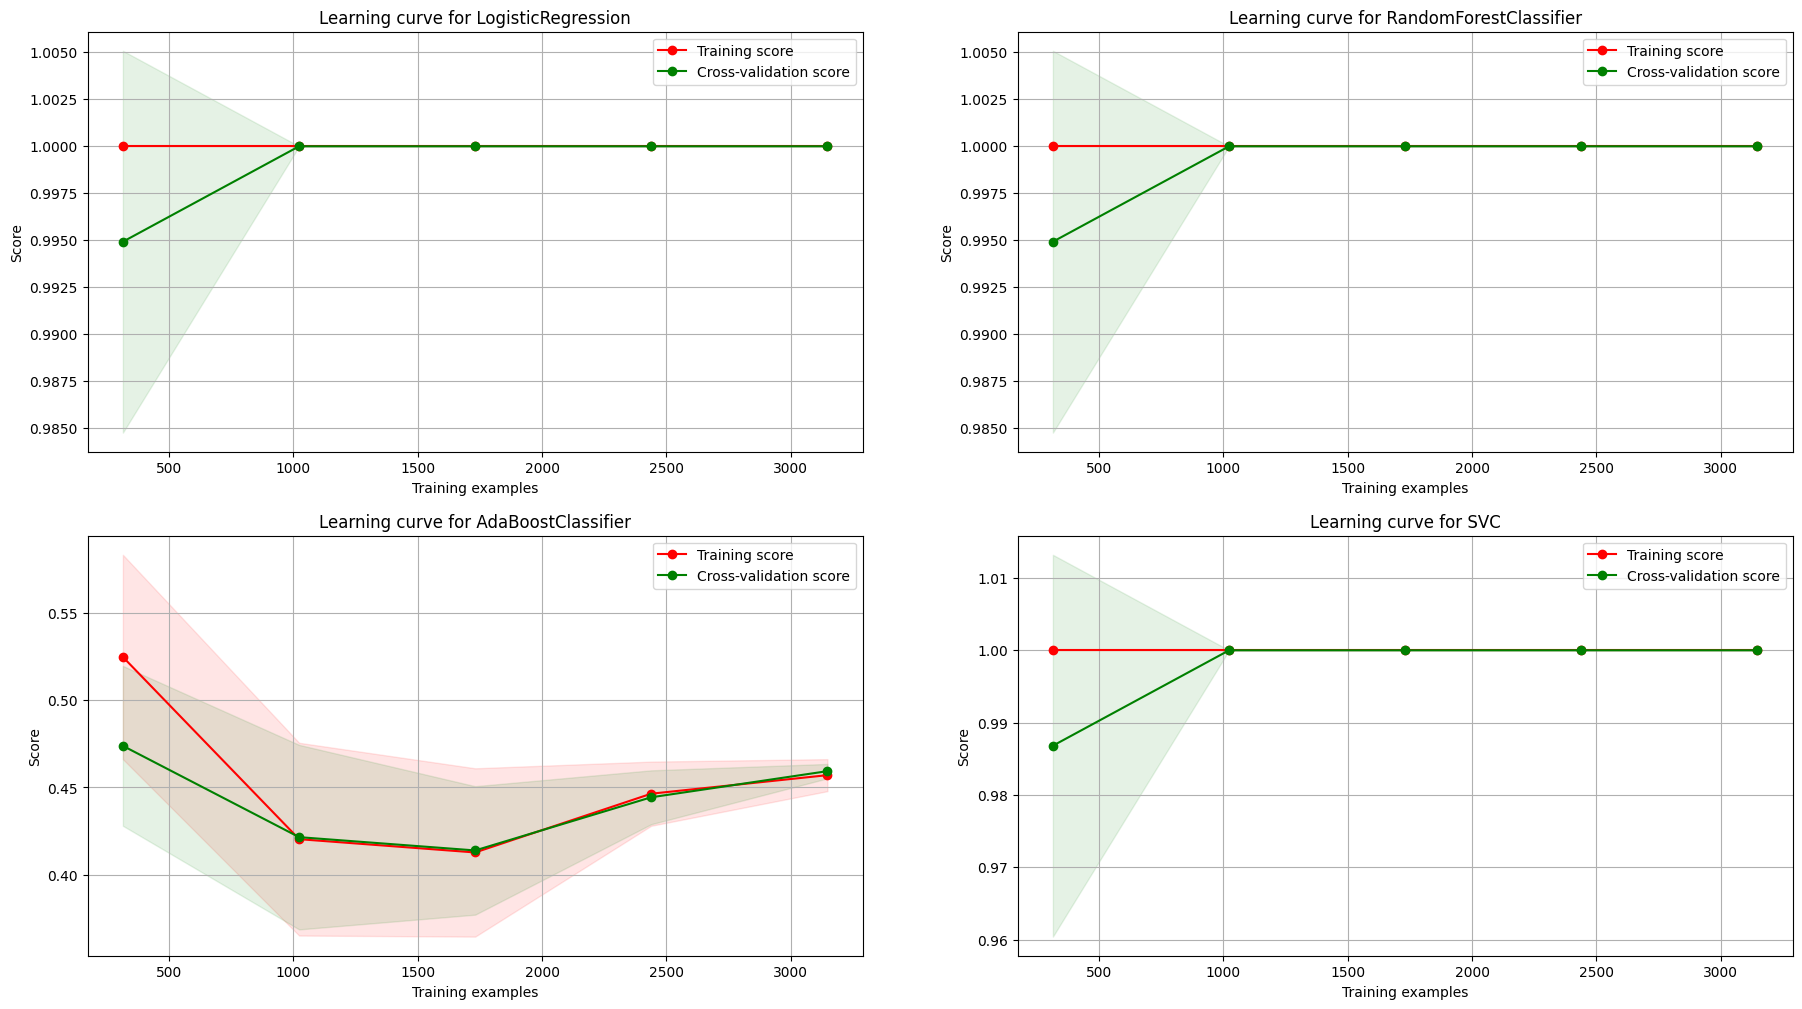

In [24]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1,estimator2,estimator3,estimator4,X,Y,ylim=None,cv=None,n_jobs=-1,train_sizes=np.linspace(.1,1.0,5)):
    fig,ax = plt.subplots(2,2,figsize=(22,12))
    if ylim is not None:
        plt.ylim(*ylim)
    n=0
    for estimator in [estimator1,estimator2,estimator3,estimator4]:
        i,j = divmod(n,2)
        train_sizes,train_scores,test_scores = learning_curve(estimator,X,Y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores,axis=1)
        train_scores_std = np.std(train_scores,axis=1)
        test_scores_mean = np.mean(test_scores,axis=1)
        test_scores_std = np.std(test_scores,axis=1)
        ax[i][j].fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,alpha=0.1,color='r')
        ax[i][j].fill_between(train_sizes,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std,alpha=0.1,color='g')
        ax[i][j].plot(train_sizes,train_scores_mean,'o-',color='r',label='Training score')
        ax[i][j].plot(train_sizes,test_scores_mean,'o-',color='g',label='Cross-validation score')
        ax[i][j].set_title("Learning curve for {}".format(estimator.__class__.__name__))
        ax[i][j].set_xlabel('Training examples')
        ax[i][j].set_ylabel('Score')
        ax[i][j].grid(True)
        ax[i][j].legend(loc='best')
        n+=1
    return plt

plot_learning_curve(log_reg,random_forest,AdaBoost,SVM,X_train,Y_train,cv=5)

Except for the AdaBoost model, all the models have no gap between the training score and the cross-validation score.

Which means that they are not overfitting or underfitting (i.e they are able to generalize well).

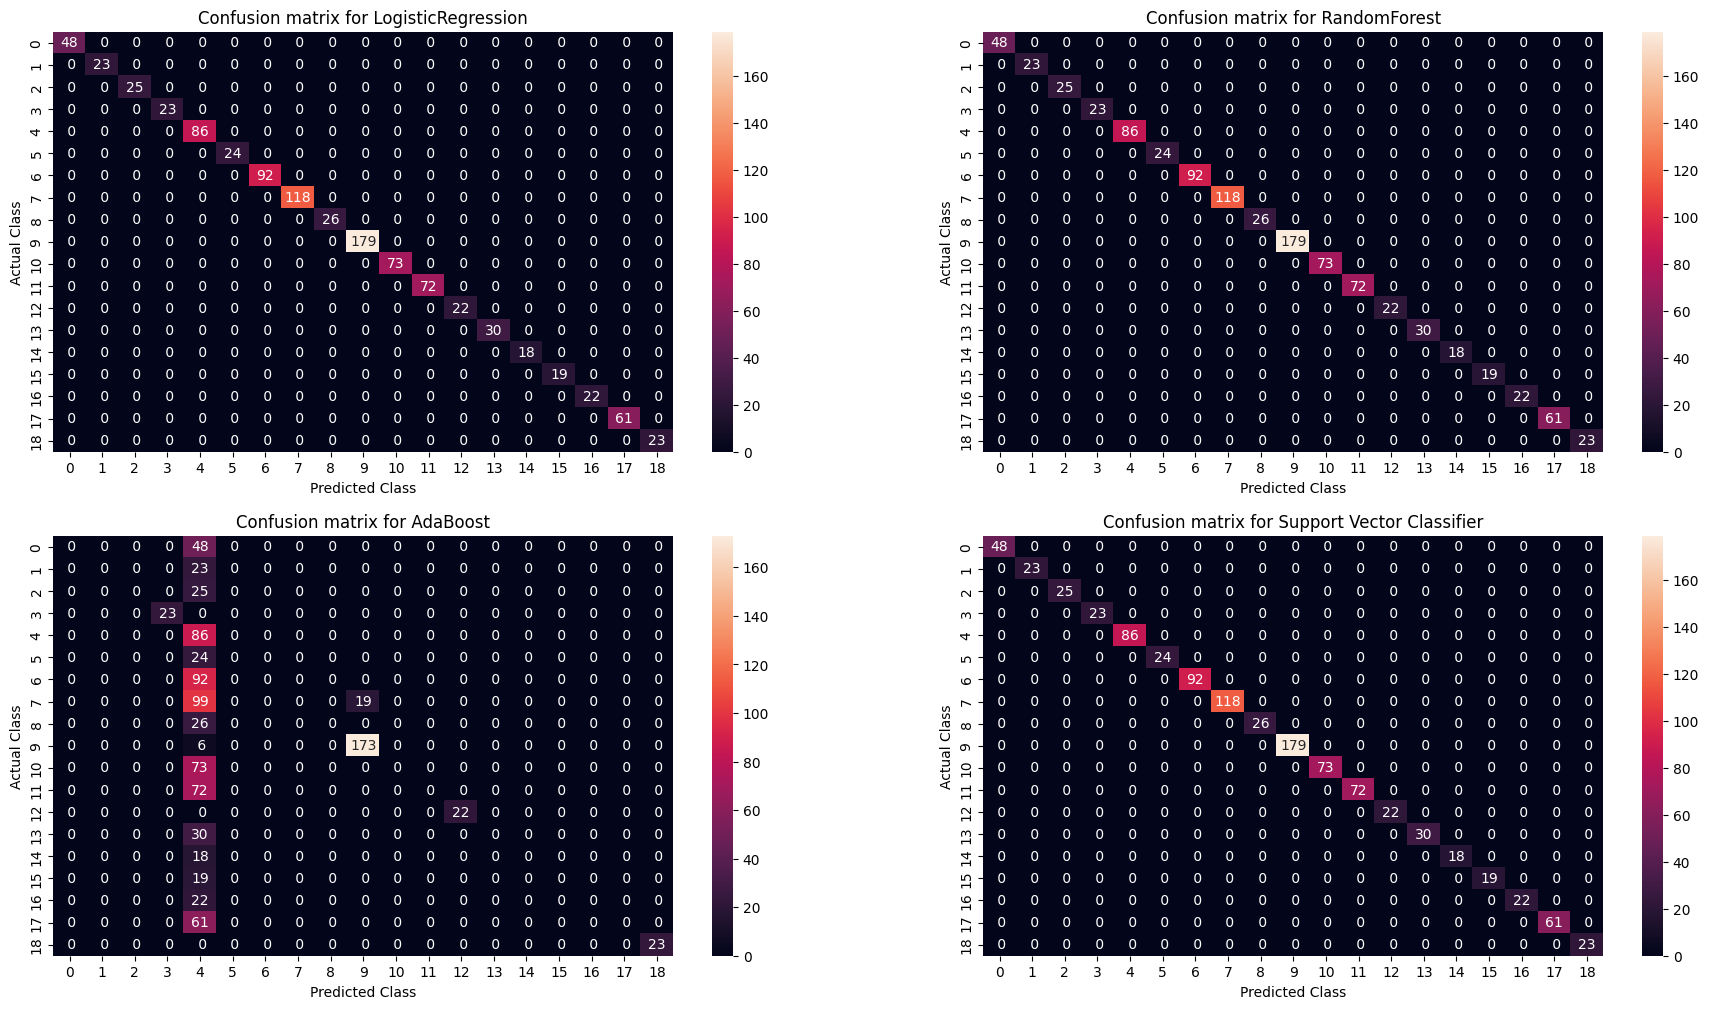

In [25]:
fig,ax = plt.subplots(2,2,figsize=(22,12))
n=0

for classifier in best_models:
    Y_pred = classifiers[classifier].predict(X_test)
    i,j = divmod(n,2)
    sns.heatmap(confusion_matrix(Y_test,Y_pred),ax=ax[i][j],annot=True,fmt='2.0f')
    ax[i][j].set_title("Confusion matrix for {}".format(classifier))
    ax[i][j].set_xlabel('Predicted Class')
    ax[i][j].set_ylabel('Actual Class')
    n+=1

Moreover, for every model except AdaBoost, the confusion matrix is diagonal, which means that the model is able to predict the class of the `Disease` variable with a high accuracy.

# Conclusion

We have trained 4 different models to predict the class of the `Disease` variable and optimized the hyperparameters of each model and we have plotted the learning curve for each model.

The only model that seems to have a problem is the AdaBoost model with a confusion matrix that predicts the same class for almost every patient.

**Limitation of the dataset**

Even though we have good results, we need to be careful with the interpretation of the results.

The dataset contains 131 binary values, which means there may be redundancy in the dataset. And therefore, the test set may contain the same values as the training set.

A dataset with data about patient symptoms, diseases, and conditions is hard to find on the Internet, because it is sensitive data.

Therefore, we need to be careful with the interpretation of the results and a dataset with more than binary values would be more reliable.